In [ ]:
#!pip install -q lovely-tensors lovely-numpy
#!git clone https://github.com/openai/guided-diffusion.git
#!wget -O checkpoint.pt https://openaipublic.blob.core.windows.net/diffusion/jul-2021/128x128_diffusion.pt # We will generate 128x128 images

In [5]:
import sys

sys.path.append('./guided-diffusion')

import guided_diffusion

In [9]:
from guided_diffusion.script_util import create_model, create_model_and_diffusion, model_and_diffusion_defaults

defaults = model_and_diffusion_defaults()

args = {
  "attention_resolutions": "32,16,8",
  "class_cond": True,
  "diffusion_steps": 1000,
  "image_size": 128,
  "learn_sigma": True,
  "noise_schedule": "linear",
  "num_channels": 256,
  "num_heads": 4,
  "num_res_blocks": 2,
  "resblock_updown": True,
  "use_fp16": True,
  "use_scale_shift_norm": True
}

defaults.update(args)

# Model and the noise diffusion process
model, diffusion = create_model_and_diffusion(**defaults)

In [10]:
import torch

ckpt = torch.load('checkpoint.pt', map_location='cpu')
model.load_state_dict(ckpt)

model = model.cuda()
model.convert_to_fp16()

model = model.eval()

/tmp/ipykernel_599133/4252540927.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('checkpoint.pt', map_location='cpu')


In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import lovely_tensors as lt

# Torch tensor to numpy image
def to_image(x):
    img = x[0].cpu().detach()
    img = (img - img.min()) / (img.max() - img.min())
    img = img.permute(1, 2, 0)
    img = img.numpy()
    img = img * 255.
    img = img.astype('uint8')
    return img


# Generate image from noise. 'y' - class (285 - cats), 'beta' - level of noise
def call_model(model, x, beta, y=285):
    t = torch.tensor([beta_to_step(beta)]).cuda()
    c = torch.tensor([y]).cuda()

    res = model.forward(x, t, c).detach()

    return res[:, :3, :, :]


# Convert time step to noise level
def step_to_beta(step):
    index = int(step // 1)
    shift = step % 1

    betas = 1.0 - diffusion.alphas_cumprod

    if index >= len(betas) - 1:
        return betas[-1]

    a = betas[index]
    b = betas[index + 1]

    return a + (b - a) * shift


# Infer time steps from beta
def beta_to_step(beta):
    betas = 1.0 - diffusion.alphas_cumprod
    index = (betas <= beta).astype(float).sum() - 1

    index = int(index)

    if index < 0:
      return 0

    if index >= len(betas) - 1:
      return len(betas) - 1

    low_beta = betas[index]
    high_beta = betas[index + 1]

    part = (beta - low_beta) / (high_beta - low_beta)
    step = index + part
    return step

In [12]:
# Generate image from noise with beta level
generator = torch.Generator().manual_seed(42)

# Generate random noise
sample = torch.randn([1, 3, 128, 128], generator=generator).cuda()

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-4.590, 4.221] μ=0.002 σ=1.007 cuda:0


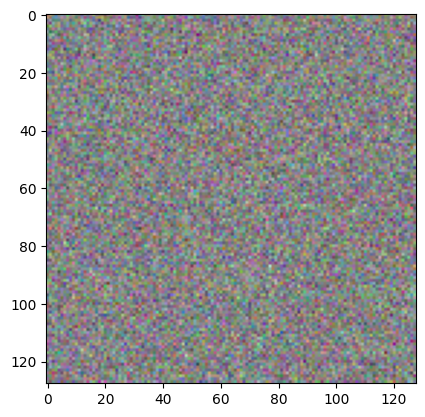

In [15]:
print(lt.lovely(sample))
plt.imshow(to_image(sample));

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-6.550, 6.239] μ=-0.008 σ=1.030 cuda:0


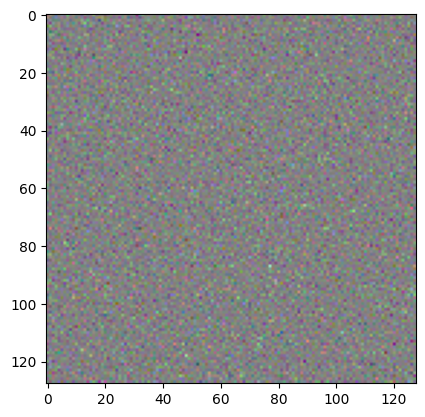

In [20]:
res = call_model(model, sample, .1) # Generate image with noise level (if beta=1, then we have the same image as before)
print(lt.lovely(res))
plt.imshow(to_image(res[:, :3]));

# DDIM Sampler

In [ ]:
# Estimate noise level and subtract it from the image, then add noise with another level (smaller)
generator = torch.Generator().manual_seed(0)

res = torch.randn([1, 3, 128, 128], generator=generator).cuda() # Sample noise

betas = np.linspace(0.001, 0.999, 1000)[::-1] # Schedule of noise levels (linear)

with torch.no_grad():
  for step in tqdm.trange(len(betas) - 1): # Iterate over noise levels

        beta_this = betas[step] # Current noise level
        beta_next = betas[step + 1] # Next noise level

        # Estimate the noise used to generate the image
        e = call_model(model, res, beta_this)

        # Subtract the noise from the image
        x0 = res - e * np.sqrt(beta_this)

        # Add noise with the next level
        res = x0/np.sqrt(1 - beta_this) * np.sqrt(1 - beta_next) + e * np.sqrt(beta_next)
# The result is quite bad, but it's a good start

  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [01:12<00:00, 13.79it/s]


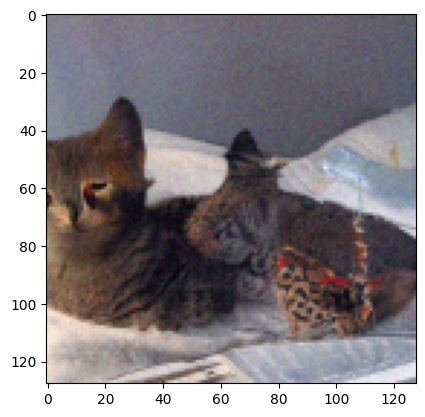

In [23]:
plt.imshow(to_image(res))

# Euler (to solve the differential equation)

In [ ]:
generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda() # Sample noise

num_steps = 1000

# Linear schedule
#betas = np.linspace(0.001, 0.999, num_steps)[::-1] # Schedule of noise levels (linear)
# Cosine schedule
betas = np.cos(np.linspace(np.acos(0.001), np.acos(0.999), num_steps))[::-1]# Schedule of noise levels (cosine)

def F(x, beta):
    coeff = 1 / (1 - beta) # Coefficient for the noise (variance preserving), BETA != 1
    with torch.no_grad():
        e = call_model(model, x, beta) # Estimate the noise
    return 0.5 * (x - e / beta ** 0.5) * coeff 


for step in tqdm.trange(len(betas) - 1):
    beta = betas[step]
    
    # According to the schedule 
    beta_next = betas[step + 1]
    dt = beta - beta_next # Step size

    res = res + F(res, beta) * dt # Differeintial equation for the noise diffusion

100%|██████████| 999/999 [01:06<00:00, 15.03it/s]


tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.999, 0.830] μ=-0.217 σ=0.370 cuda:0


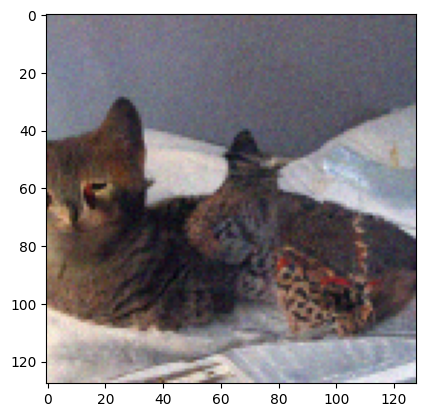

In [54]:
print(lt.lovely(res))
plt.imshow(to_image(res));

# Heun's Solver (Another solver of differential equations, 2nd order)

In [56]:
generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

num_steps = 1000

# Linear schedule
#betas = np.linspace(0.001, 0.999, num_steps)[::-1] # Schedule of noise levels (linear)
# Cosine schedule
betas = np.cos(np.linspace(np.acos(0.001), np.acos(0.999), num_steps))[::-1]# Schedule of noise levels (cosine)

for step in tqdm.trange(len(betas) - 1):
    beta = betas[step]

    # According to the schedule 
    beta_next = betas[step + 1]
    dt = beta - beta_next # Step size

    k1 = F(res, beta) # First velocity
    if step != 0:
        k2 = F(res + k1 * dt, beta - dt) # Second velocity
    else:
        k2 = k1

    res = res + (k1 + k2) * dt / 2 # Average velocity

100%|██████████| 999/999 [02:24<00:00,  6.91it/s]


tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.978, 0.819] μ=-0.214 σ=0.367 cuda:0


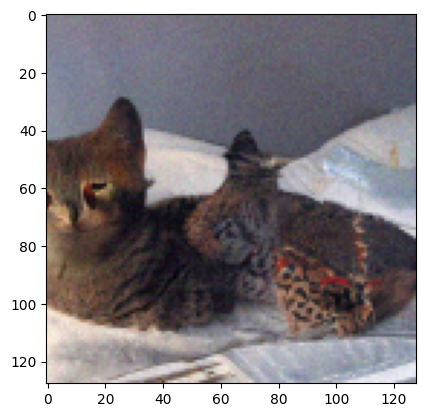

In [57]:
print(lt.lovely(res))
plt.imshow(to_image(res));

# Adams-Bashforth solver (2nd order)

In [ ]:
generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

num_steps = 1000

# Linear schedule
#betas = np.linspace(0.001, 0.999, num_steps)[::-1] # Schedule of noise levels (linear)
# Cosine schedule
betas = np.cos(np.linspace(np.acos(0.001), np.acos(0.999), num_steps))[::-1]# Schedule of noise levels (cosine)

k1_old = None 
for step in tqdm.trange(len(betas) - 1):
    beta = betas[step]
    
    # According to the schedule 
    beta_next = betas[step + 1]
    dt = beta - beta_next # Step size

    k1 = F(res, beta)
    if step != 0:
        k2 = k1_old
    else:
        k2 = k1
    k1_old = k1

    res = res + ((3/2) * k1 - (1/2) * k2) * dt

100%|██████████| 999/999 [01:04<00:00, 15.47it/s]


tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.981, 0.822] μ=-0.219 σ=0.368 cuda:0


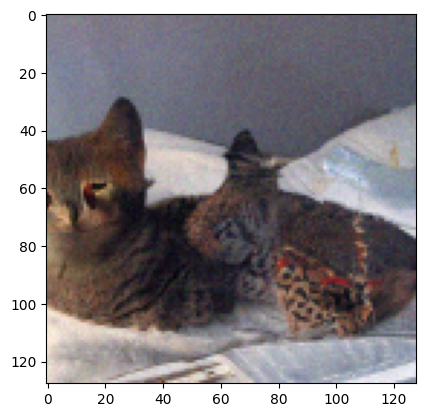

In [33]:
print(lt.lovely(res))
plt.imshow(to_image(res));

# Runge-Kutta solver (4th order)

In [ ]:

generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

num_steps = 1000

# Linear schedule
#betas = np.linspace(0.001, 0.999, num_steps)[::-1] # Schedule of noise levels (linear)
# Cosine schedule
betas = np.cos(np.linspace(np.acos(0.001), np.acos(0.999), num_steps))[::-1]# Schedule of noise levels (cosine)

for step in tqdm.trange(num_steps - 1):
    beta = betas[step]
    
    # According to the schedule 
    beta_next = betas[step + 1]
    dt = beta - beta_next # Step size

    k1 = F(res, beta)
    if step != 0:
        # Minus dt/2 because we need to go back in time
        k2 = F(res + k1 * dt / 2, beta - dt / 2) 
        k3 = F(res + k2 * dt / 2, beta - dt / 2)
        k4 = F(res + k3 * dt, beta - dt)
    else:
        k2 = k1
        k3 = k1
        k4 = k1

    res = res + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6

100%|██████████| 999/999 [04:46<00:00,  3.48it/s]


tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.975, 0.821] μ=-0.215 σ=0.368 cuda:0


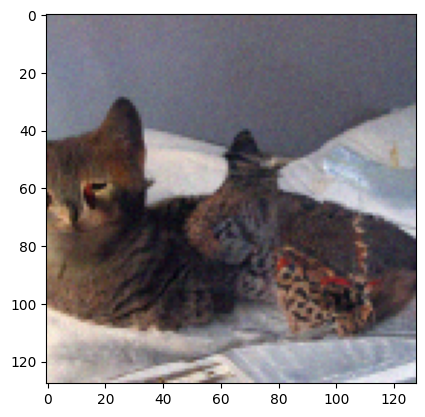

In [ ]:
print(lt.lovely(res))
plt.imshow(to_image(res));

In order to improve the quality of the image, we can change the scheduler, for instance, by making it smaller for large beta values. Also, we have noise in the final image, which means we finish too early.